In [55]:
import torch
import utils
import nets_LV
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import copy
from sklearn.metrics import precision_score, accuracy_score

In [56]:
transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=.3, hue=.2),
    # transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ToTensor()
])

In [57]:
device = torch.device('mps')

In [58]:
lambda_set = '../../../../../project/gpuuva022/shared/AnomalyDetection/FFHQ_Data/FFHQ_data/l_tuning'
images_pixel_score_path = '../../data/thresholding_images/'#'/home/lcur1737/AnomalyDetection/data/thresholding_images'

# val_dataset = ImageFolder(lambda_set, transform=transform_pipeline)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
pixel_score_set = ImageFolder(images_pixel_score_path, transform=transform_pipeline)
pixel_score_loader = DataLoader(pixel_score_set, batch_size=1, shuffle=True)

In [59]:
vqvae_checkpoint_path = '../../checkpoints/ffhq_continued_020.pt' #'/home/lcur1737/AnomalyDetection/src/checkpoints/VQVAE/ffhq_continued_020.pt'
ar_checkpoint_path = '../../checkpoints/ffhq_ar_030.pt' #'/home/lcur1737/AnomalyDetection/src/checkpoints/AR/ffhq_ar_030.pt'

In [61]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vq_model = nets_LV.VQVAE(
    d=3,
    n_channels=(16, 32, 64, 256),
    code_size=128,
    n_res_block=2,
    dropout_p=.1
).to(device)

vqvae_checkpoint = torch.load(vqvae_checkpoint_path, map_location=device)
vq_model.load_state_dict(vqvae_checkpoint["model"])
vq_model = vq_model.to(device)

ar_model = nets_LV.VQLatentSNAIL(
    feature_extractor_model=vq_model,
    shape=(16, 16),
    n_block=4,
    n_res_block=4,
    n_channels=128
).to(device)

ar_checkpoint = torch.load(ar_checkpoint_path, map_location=device)

ar_model.load_state_dict(ar_checkpoint['model'])

ar_model = ar_model.to(device)

# Sample wise score threshold

In [ ]:
pred = []
accuracy = []
labels = []
ar_model.eval()

# 0 is fake
# 1 is real
thresholds = np.linspace(1,20,2)

loaded_dataloader = tqdm(val_dataloader)
print('Starting the measurements')
for thr in thresholds:
    print('for threshold', thr)
    temp_preds = []
    temp_labels = []
    for batchX, batchY in loaded_dataloader:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        with torch.no_grad():
            loss = ar_model.loss(batchX, reduction='none')['loss'].flatten(1)

            score = torch.sum(loss*(loss>thr), 1).float()
            temp_preds.extend(score.cpu().numpy())
            temp_labels.extend(batchY.cpu().numpy())

    pred.append(temp_preds)
    labels.append(temp_labels)

    


## Find best threshold

In [ ]:

acc_per_thr = []
prec_per_thr = []

for threshold_idx, prediction in enumerate(pred):
    pred_copy = np.array(copy.deepcopy(prediction))
    real_preds = pred_copy[np.array(labels)[threshold_idx] == 1]
    fake_preds = pred_copy[np.array(labels)[threshold_idx] == 0]
    
    max_real = np.max(real_preds)
    min_fake = np.min(fake_preds)
    
    avg_thr = np.mean([max_real, min_fake])
    #Below are real
    pred_copy[pred_copy <= avg_thr] = 1
    
    #Above are fake
    pred_copy[pred_copy > avg_thr] = 0
    acc_per_thr.append(accuracy_score(labels[threshold_idx], pred_copy))
    prec_per_thr.append(precision_score(labels[threshold_idx], pred_copy))


best_threshold = np.argmax(acc_per_thr)
print('best threshold value is', thresholds[best_threshold])
    

# Find pixel score threshold

In [65]:
def reconstruct(n, img, threshold_log_p = 5):
    """ Generates n reconstructions for each image in img.
    Resamples latent variables with cross-entropy > threshold
    Returns corrected images and associated latent variables"""
          
    #Use VQ-VAE to encode original image
    codes = ar_model.retrieve_codes(img)
    code_size = codes.shape[-2:]
    

    with torch.no_grad():
        samples = codes.clone().unsqueeze(1).repeat(1,n,1,1).reshape(img.shape[0]*n,*code_size)

        if not threshold_log_p == None:
            for r in tqdm(range(code_size[0])):
                for c in range(code_size[1]):        

                    code_logits = ar_model.forward_latent(samples)[:,:,r,c]
                    loss = F.cross_entropy(code_logits, samples[:, r, c], reduction='none')
                    probs = F.softmax(code_logits, dim=1)

                    samples[loss > threshold_log_p, r, c] = torch.multinomial(probs, 1).squeeze(-1)[loss > threshold_log_p]

        z = vq_model.codebook.embedding(samples.unsqueeze(1))
        z = z.squeeze(1).permute(0,3,1,2).contiguous()
        
        # Split the calculation in batches
        x_tilde = []
        for i in range(img.shape[0]):
            x_tilde.append(vq_model.decode(z[i*n:(i+1)*n]))
        x_tilde = torch.cat(x_tilde)
        
        
    return x_tilde.reshape(img.shape[0]*img.shape[1],n,*img.shape[-2:]), samples.reshape(img.shape[0],n,*code_size)

reconstructions = []

# for X,_ in loaded_dataloader:
#     x_tilde, latent_sample = reconstruct(n=15,img=X, threshold_log_p=5)
#     reconstructions.append(x_tilde)

## 5 images experiment

In [80]:
import matplotlib.pyplot as plt

In [84]:
X = next(iter(pixel_score_loader))[0]
reconstructionmax = reconstruct(n=5,img=X, threshold_log_p=None)[0]
reconstruction8 = reconstruct(n=5,img=X, threshold_log_p=8)[0]
reconstruction9 = reconstruct(n=5,img=X, threshold_log_p=9)[0]

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


100%|██████████| 16/16 [04:56<00:00, 18.56s/it]


torch.Size([1, 3, 128, 128])


100%|██████████| 16/16 [04:10<00:00, 15.68s/it]


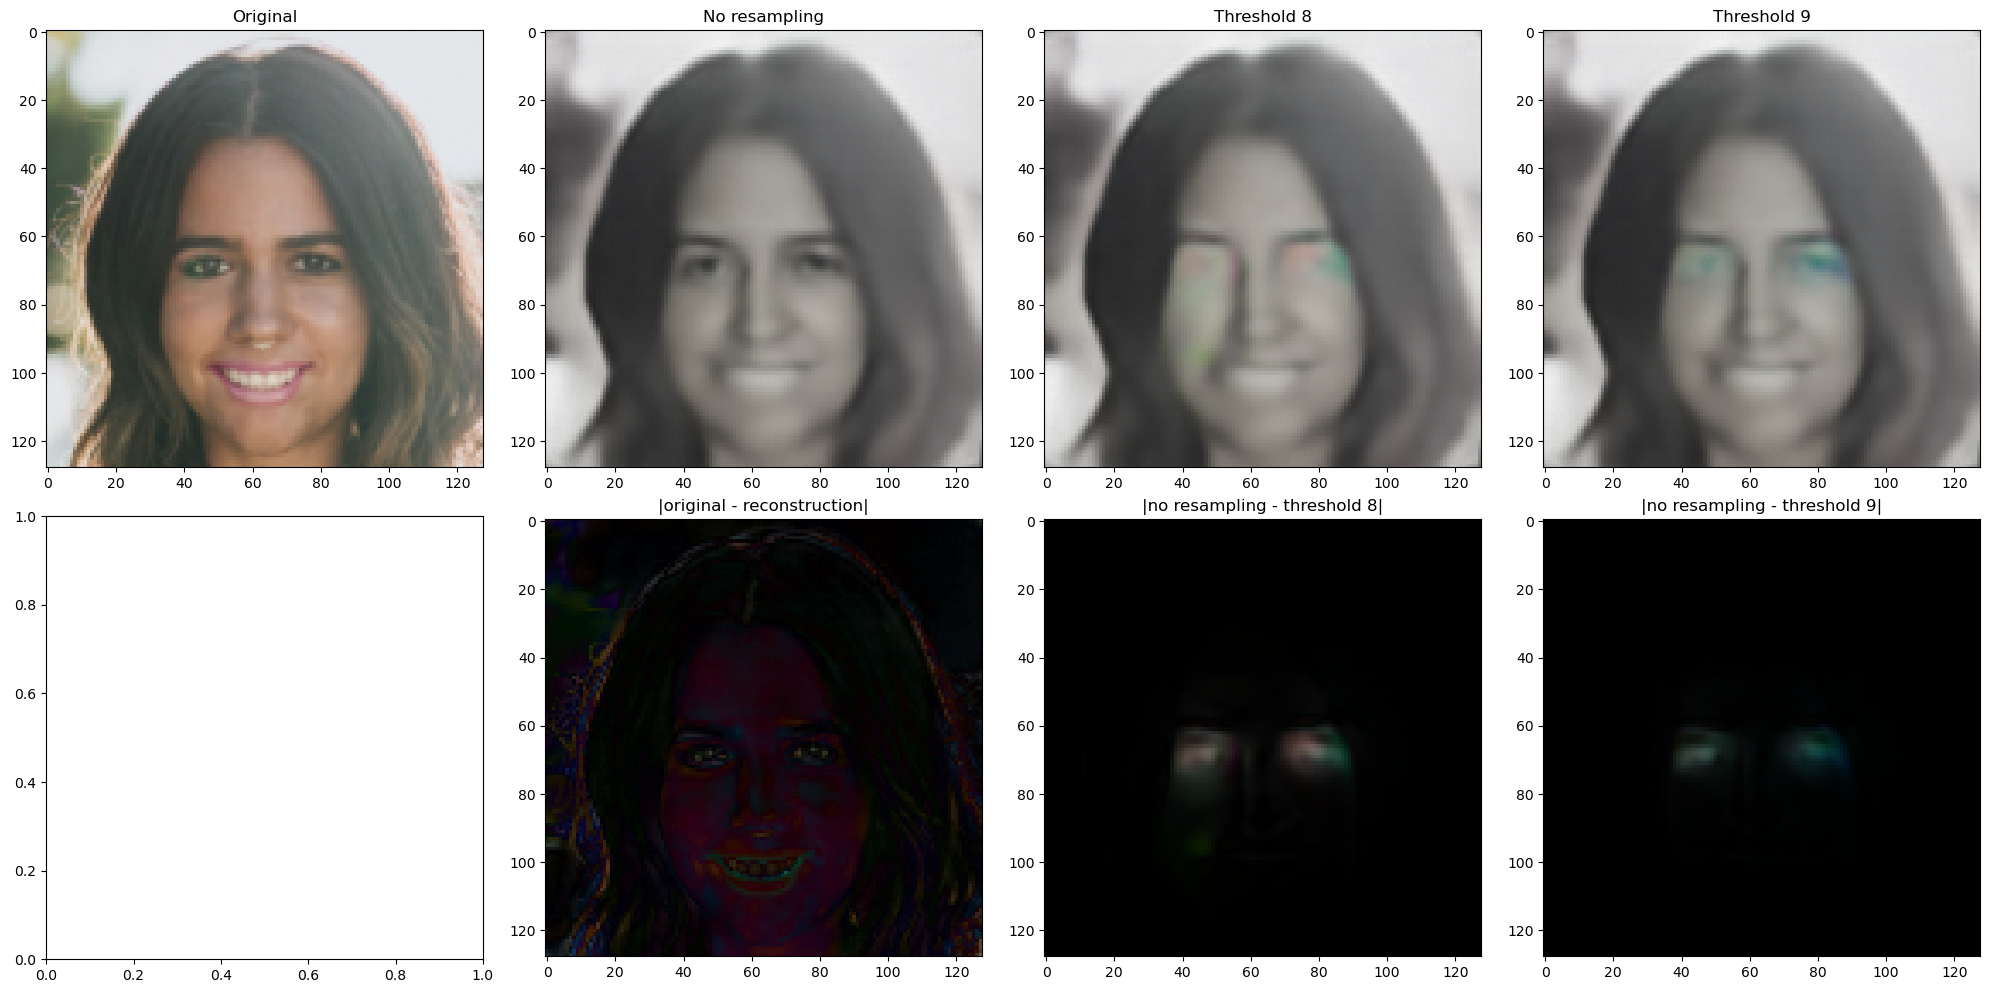

In [85]:
diffrec = torch.abs(X[0] - torch.mean(reconstructionmax, dim=1))
diff8 = torch.mean(torch.abs(reconstructionmax - reconstruction8), dim=1)
diff9 = torch.mean(torch.abs(reconstructionmax - reconstruction9), dim=1)
reconstructionmax = torch.mean(reconstructionmax, dim=1)
reconstruction8 = torch.mean(reconstruction8, dim=1)
reconstruction9 = torch.mean(reconstruction9, dim=1)

fig, axes = plt.subplots(2,4, figsize=(20,10))

axes[0,0].imshow(X[0].permute(1,2,0))
axes[0,0].set_title('Original')
axes[0,1].imshow(reconstructionmax.squeeze().permute(1,2,0))
axes[0,1].set_title('No resampling')
axes[0,2].imshow(reconstruction8.squeeze().permute(1,2,0))
axes[0,2].set_title('Threshold 8')
axes[0,3].imshow(reconstruction9.squeeze().permute(1,2,0))
axes[0,3].set_title('Threshold 9')
axes[1,1].imshow(diffrec.squeeze().permute(1,2,0))
axes[1,1].set_title('|original - reconstruction|')
axes[1,2].imshow(diff8.squeeze().permute(1,2,0))
axes[1,2].set_title('|no resampling - threshold 8|')
axes[1,3].imshow(diff9.squeeze().permute(1,2,0))
axes[1,3].set_title('|no resampling - threshold 9|')

plt.tight_layout()
plt.show()
